<a href="https://colab.research.google.com/github/cccg8105/notebook_AD/blob/master/template%20Series%20temporales/SARIMAX.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Modelo autoregresivo integrado de medias móviles estacional

SARIMAX(p, d, q)(P, D, Q, s)

s = cantidad de peridods que tienen que pasar para que el patrón se repita.

$$ \Delta X_{t} = \beta Y + \sum_{a=1}^{q}\varphi_{a}\Delta X_{t-a}+\sum_{a=0}^{q}\vartheta_{a}\varepsilon_{t-a} + \sum_{n =1}^{P}(\phi_{n}(\sum_{a=0}^{p}X_{t-ns-a})) + \sum_{n =1}^{Q}(\theta_{n}(\sum_{a=0}^{q}\varepsilon_{t-ns-a})) + C $$
$$ \Delta X_{t} = X_{t} - X_{t-1}$$



Si se usa la varibale exogena es necesario conocer los valores futuros de la misma al momento de predecir datos desconocidos

## Importación de datos

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.graphics.tsaplots as sgt
import statsmodels.tsa.stattools as sts
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from scipy.stats.distributions import chi2 
from math import sqrt
import seaborn as sns
sns.set()

import warnings
warnings.filterwarnings("ignore")
sns.set()

#Prueba Logverosimilitud
# requiere que los modelos esten anidados
# p1 + q1 > p2 +q2
# p1 >= p2
# q1 >= q2
def LLR_test(mod_1, mod_2, DF = 1):
    L1 = mod_1.llf
    L2 = mod_2.llf
    LR = (2*(L2-L1))    
    p = chi2.sf(LR, DF).round(3)
    return p

# carga de archivo
raw_csv_data = pd.read_csv("https://raw.githubusercontent.com/cccg8105/curso-series-temporales/master/7.%20ARMA%20autorregresivos%20de%20medias%20moviles/Python/Index2018.csv")
dateColumnName = "date"
analizedValue = "ftse"
variablesExogenas = ['spx','dax','nikkei']
unused_columns = ['spx','dax','ftse','nikkei']

nroRetrasos = 40
ratioConfianza = 0.95

# Formateo de dataset
df_comp=raw_csv_data.copy()
df_comp.date = pd.to_datetime(df_comp[dateColumnName], dayfirst = True)
df_comp.set_index(dateColumnName, inplace=True)
df_comp=df_comp.asfreq('b')
df_comp=df_comp.fillna(method='ffill')
df_comp['analizedValue']=df_comp[analizedValue]
# dataframe de series exogenas
dfExog = df_comp[variablesExogenas]

# Se eliminan columnas no usadas
df_comp = df_comp.drop(unused_columns, axis=1)
# data frame para analizar
df_comp.head(5)

,analizedValue
date,
1994-01-07,3445.98
1994-01-10,3440.58
1994-01-11,3413.77
1994-01-12,3372.02
1994-01-13,3360.01


## Descomposición de serie temporal

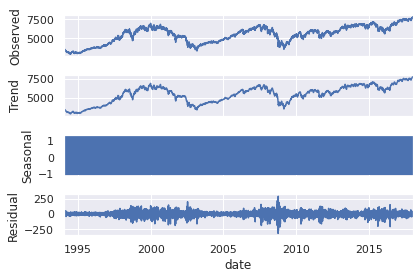

In [30]:
from statsmodels.tsa.seasonal import seasonal_decompose      # ETS Plots

result = seasonal_decompose(df_comp['analizedValue'], model='add')
result.plot();

## Separación entrenamiento y datos de prueba

In [4]:
porcentajeEntrenamiento = 0.8
size = int(len(df_comp)*porcentajeEntrenamiento)
df, df_test = df_comp.iloc[:size], df_comp.iloc[size:]
dfex, dfex_test = dfExog.iloc[:size], dfExog.iloc[size:]
df['returns'] = df.analizedValue.pct_change(1)*100

## SARIMAX

In [28]:
p = 1
d = 0
q = 1
P = 2
D = 0
Q = 1
s = 5

model_sarimax = SARIMAX(df.analizedValue, exog = dfex, order=(p,d,q), seasonal_order = (P,D,Q,s))
results_sarimax = model_sarimax.fit()
results_sarimax.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                
=========================================================================================
Dep. Variable:                     analizedValue   No. Observations:                 5021
Model:             SARIMAX(1, 0, 1)x(2, 0, 1, 5)   Log Likelihood              -25000.264
Date:                           Mon, 16 Nov 2020   AIC                          50018.528
Time:                                   16:38:46   BIC                          50077.220
Sample:                               01-07-1994   HQIC                         50039.094
                                    - 04-05-2013                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
spx            0.4472      0.031     14.547      0.000       0.387       0.507
dax            0.5786      0.006    102.055      0.000       0.568       0.590
nikkei         0.0262      0.002     12.617      0.000       0.022       0.030
ar.L1          0.9966      0.001   1116.050      0.000       0.995       0.998
ma.L1         -0.0855      0.009     -9.978      0.000      -0.102      -0.069
ar.S.L5        0.9565      0.014     69.761      0.000       0.930       0.983
ar.S.L10       0.0332      0.011      3.014      0.003       0.012       0.055
ma.S.L5       -0.9828      0.008   -123.283      0.000      -0.998      -0.967
sigma2      1229.8845     14.307     85.962      0.000    1201.843    1257.926
===================================================================================
Ljung-Box (Q):                       87.01   Jarque-Bera (JB):              5571.65
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.94   Skew:                             0.01
Prob(H) (two-sided):                  0.18   Kurtosis:                         8.16
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

## Predicción

In [17]:
start=len(df)
end=len(df)+len(df_test)-1
predictions = results_sarimax.predict(start=start, end=end, exog = dfex_test).rename('SARIMA(1,0,1)(2,0,1,5) Predictions')

### Comparación de resultados

In [8]:
# Compare predictions to expected values
for i in range(len(predictions)):
    print(f"predicted={predictions[i]:<11.10}, expected={df_test['analizedValue'][i]}")

predicted=6264.572229, expected=6276.94
predicted=6253.130094, expected=6313.2
predicted=6362.175533, expected=6387.37
predicted=6406.930328, expected=6416.14
predicted=6327.973167, expected=6384.39
predicted=6286.124035, expected=6343.597833
predicted=6277.60918 , expected=6304.57777
predicted=6164.681207, expected=6244.206257
predicted=6137.157823, expected=6243.671239
predicted=6135.879887, expected=6286.594842
predicted=6154.78421 , expected=6280.616017
predicted=6265.632256, expected=6406.120876
predicted=6329.083493, expected=6431.760795
predicted=6375.233201, expected=6442.594256
predicted=6360.444513, expected=6426.424009
predicted=6398.105248, expected=6458.022747
predicted=6422.897436, expected=6430.116626
predicted=6411.566592, expected=6451.289289
predicted=6441.676211, expected=6460.71305
predicted=6540.228662, expected=6521.45633
predicted=6534.299265, expected=6521.45633
predicted=6591.496217, expected=6557.304271
predicted=6633.525983, expected=6583.4819990000005
predic

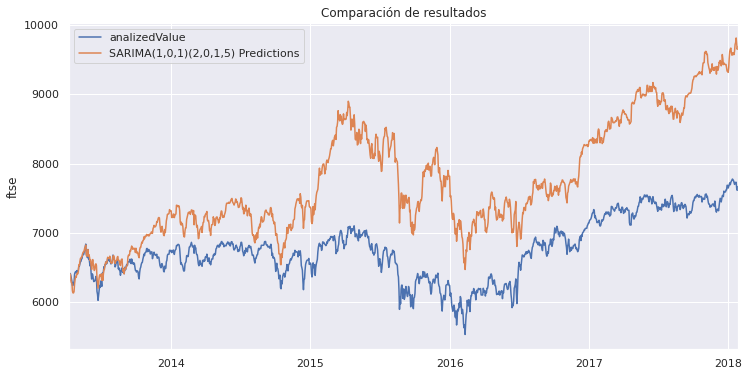

In [18]:
# Plot predictions against known values
title ='Comparación de resultados'
ylabel='ftse'
xlabel=''

ax = df_test['analizedValue'].plot(legend=True,figsize=(12,6),title=title)
predictions.plot(legend=True)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel);

### Predicción de datos desconocidos

In [31]:
periodosFuturos = 36
model = SARIMAX(df_comp['analizedValue'],order=(p,d,q),seasonal_order=(P,D,Q,s), exog = dfExog)
results = model.fit()
fcast = results.predict(len(df_comp),len(df_comp)+periodosFuturos, exog = dfExog.iloc[len(dfExog)-periodosFuturos-1:]).rename('SARIMA(1,0,1)(2,0,1,5) Forecast')

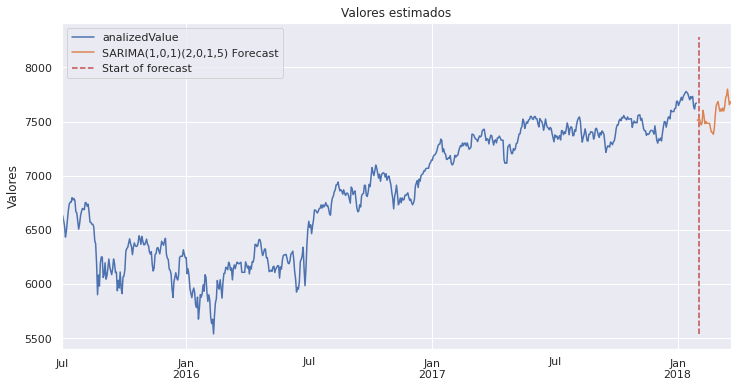

In [38]:
title = 'Valores estimados'
ylabel='Valores'
xlabel=''
fecha = '2015-07-01'
valueTop = max(df_comp['analizedValue'][fecha:])+500
valueBottom = min(df_comp['analizedValue'][fecha:]) 
ax = df_comp['analizedValue']['2015-07-01':].plot(legend=True,figsize=(12,6),title=title)
plt.vlines('2018-02', valueBottom, valueTop, linestyle='--', color='r', label='Start of forecast');
fcast.plot(legend=True)
ax.set(xlabel=xlabel, ylabel=ylabel);
plt.legend(loc='upper left')